In [1]:
using Gen
using Plots
using Logging
Logging.disable_logging(Logging.Info)

LogLevel(1)

In [2]:
# Define firefly observation model
@gen function single_firefly(scene_size::Int, steps::Int)
    # sample number of fireflies
    xs = zeros(steps)
    ys = zeros(steps)
    vxs = zeros(steps)
    vys = zeros(steps) 
    blinking = zeros(steps)
    blink_freq = {:freq} ~ normal(0.25, 0.05)

    for t in 1:steps
        if t == 1
            xs[t] = {(:x, t)} ~ uniform_discrete(1, scene_size - 1)
            ys[t] = {(:y, t)} ~ uniform_discrete(1, scene_size - 1)
            vxs[t] = {(:vx, t)} ~ uniform_discrete(-1, 1)
            vys[t] = {(:vy, t)} ~ uniform_discrete(-1, 1)
        else
            prev_x = xs[t - 1]
            prev_y = ys[t - 1]
            vx = vxs[t - 1]
            vy = vys[t - 1]
            if prev_x + vx < 0 || prev_x + vx > scene_size 
                vx = -vx
            end
            if prev_y + vy < 0 || prev_y + vy > scene_size 
                vy = -vy
            end
            
            xs[t] = {(:x, t)} ~ normal(prev_x + vx, 0.05)
            ys[t] = {(:y, t)} ~ normal(prev_y + vy, 0.05)
            vxs[t] = {(:vx, t)} ~ uniform_discrete(-1, 1)
            vys[t] = {(:vy, t)} ~ uniform_discrete(-1, 1)
        end

        blinking[t] = {(:blinking, t)} ~ bernoulli(blink_freq)
    end
    
    return Dict("xs" => xs, "ys" => ys, "blink_freq" => blink_freq, "blinking" => blinking)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##single_firefly#312", Bool[0, 0], false)

In [3]:
function visualize_trace(tr)
    plot()
    scene_size, steps = get_args(tr)
    retval = get_retval(tr)
    xs = retval["xs"]
    ys = retval["ys"]
    choices = get_choices(tr)
    blink_freq = choices[:freq]

    anim = Plots.@animate for i in 1:steps
        fig = plot(layout = grid(1,2), legend=false, size=(800, 400))
        if i > 1
            plot!(fig[1], xs[1:i], ys[1:i], color=colormap("Blues", i), markersize=2, label=nothing, 
            xlim=(0, scene_size), ylim=(0, scene_size), title="Actual Location (T=$i)")
        end
        
        blinking = Int(choices[(:blinking, i)])
        if blinking == 1
            scatter!(fig[2], [xs[i]], [ys[i]], color="yellow", markersize=10, label=nothing, 
            xlim=(0, scene_size), ylim=(0, scene_size), title="Observed Location (T=$i)") 
            scatter!(fig[1], [xs[i]], [ys[i]], color="yellow", markersize=10, label=nothing, 
            xlim=(0, scene_size), ylim=(0, scene_size)) 
        else
            scatter!(fig[2], [], [], label=nothing, 
            xlim=(0, scene_size), ylim=(0, scene_size), title="Observed Location (T=$i)")
            scatter!(fig[1], [xs[i]], [ys[i]], markercolor=RGBA(1, 1, 1, 0), markersize=10, label=nothing, 
            xlim=(0, scene_size), ylim=(0, scene_size)) 
        end

        xlims!(0, scene_size)
        ylims!(0, scene_size)
    end
    return anim
end


visualize_trace (generic function with 1 method)

Plots.AnimatedGif("/Users/yonifriedman/Research/ProbComp/Fireflies/tmp.gif")
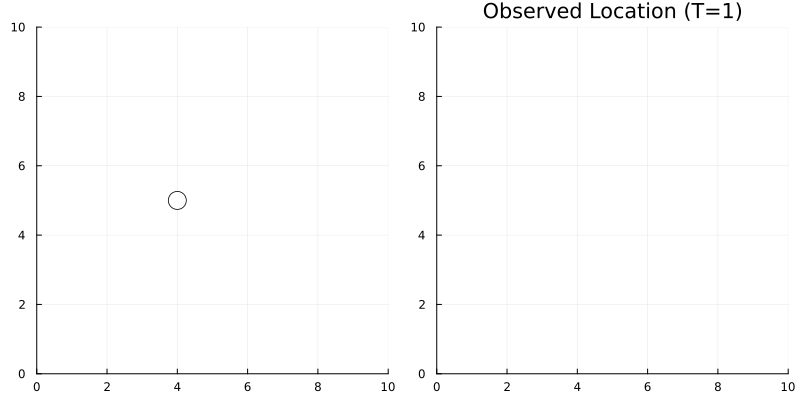

In [4]:
scene_size = 10
steps = 50
actual_trace = simulate(single_firefly, (scene_size, steps))
gif(visualize_trace(actual_trace), fps=5)


In [5]:
function make_constraints(trace)
    constraints = choicemap()
    choices = get_choices(trace)
    scene_size, t = get_args(trace)

    for i in 1:t
        x = choices[(:x, i)]
        y = choices[(:y, i)]
        blinking = choices[(:blinking, i)]
        if Int(blinking) == 1 
            constraints[(:x, i)] = x
            constraints[(:y, i)] = y
            constraints[(:blinking, i)] = blinking
        end
    end
    return constraints
end

make_constraints (generic function with 1 method)

In [6]:
constraints = make_constraints(actual_trace)

│
├── (:y, 14) : 8.35522958012904
│
├── (:y, 50) : 5.92735426908848
│
├── (:blinking, 10) : true
│
├── (:y, 3) : 5.998295862462486
│
├── (:y, 29) : 6.035781168820079
│
├── (:x, 3) : 1.9672782140932312
│
├── (:x, 48) : 1.1375617878772089
│
├── (:y, 22) : 7.09482221608462
│
├── (:y, 25) : 6.139356728566053
│
├── (:blinking, 44) : true
│
├── (:x, 25) : 0.17631145069478182
│
├── (:x, 49) : 2.1122248905800127
│
├── (:x, 14) : 0.14289058310940955
│
├── (:blinking, 22) : true
│
├── (:blinking, 45) : true
│
├── (:blinking, 5) : true
│
├── (:y, 45) : 6.847500376987319
│
├── (:y, 5) : 4.068275551488612
│
├── (:blinking, 35) : true
│
├── (:x, 29) : 3.152439755988061
│
├── (:x, 40) : 2.0450162265031673
│
├── (:x, 35) : 2.0231982381156723
│
├── (:x, 45) : 2.0385405893131328
│
├── (:blinking, 25) : true
│
├── (:y, 40) : 6.858207335549728
│
├── (:x, 9) : 2.077098614822315
│
├── (:x, 10) : 3.113317062907775
│
├── (:x, 6) : 2.992186956641759
│
├── (:blinking, 40) : true
│
├── (:y, 44) : 7.8080362672407

In [7]:
tr, w = generate(single_firefly, (scene_size, steps), constraints)
println(w)

-10859.549823714648


In [8]:
compute_steps = 10000
(trace, w) = Gen.importance_resampling(single_firefly, (scene_size, steps,), constraints, compute_steps);

Plots.AnimatedGif("/Users/yonifriedman/Research/ProbComp/Fireflies/tmp.gif")
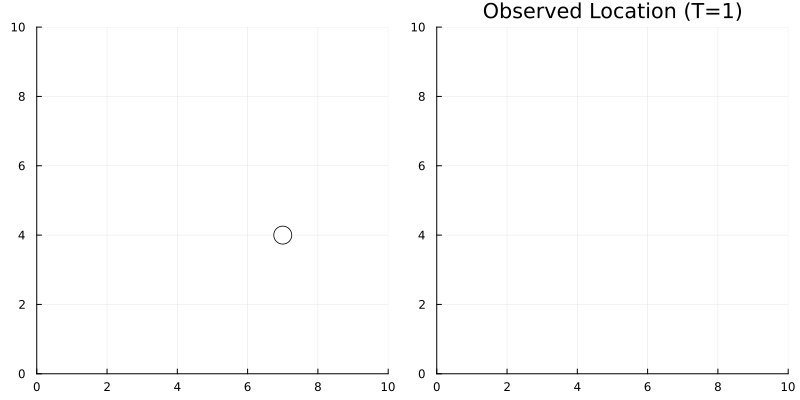

In [9]:
gif(visualize_trace(trace), fps=5)

In [13]:
function get_observation(constraints::ChoiceMap, max_t::Int)
    obs = choicemap()
    for t in 1:max_t
        if Gen.has_value(constraints, (:blinking, t))
            obs[(:x, t)] = constraints[(:x, t)]
            obs[(:y, t)] = constraints[(:y, t)]
            obs[(:blinking, t)] = constraints[(:blinking, t)]
        end
    end
    return obs
end

function particle_filter_no_resampling(num_steps::Int, scene_size::Int, num_particles::Int, observations::ChoiceMap, num_samples::Int)
    
    init_obs = get_observation(observations, 1)
    state = Gen.initialize_particle_filter(single_firefly, (num_steps, scene_size,), init_obs, num_particles)

    # steps
    for t=2:num_steps
        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        obs = get_observation(observations, t)
        Gen.particle_filter_step!(state, (num_steps, scene_size,), (UnknownChange(),), obs)
    end

    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;


In [20]:
@time pf_traces_no_resampling = particle_filter_no_resampling(steps, scene_size, 10000, constraints, 100000);

LoadError: Choices were updated or deleted inside particle filter step: DynamicChoiceMap(Dict{Any, Any}((:y, 3) => 11.111924555677776, (:x, 3) => 48.93376115584249, (:blinking, 3) => false), Dict{Any, Any}())